### The main questions of the research is whether a product can be can be classified as a top 5% popular based on early limited data.

In [1]:
import numpy as np 
import pandas as pd

In [2]:
customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
geolocations = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")

products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")
sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")

Data quality check
1. Data Quality Checks (Critical)
This is the core of primary analysis.
- Missing Values
For each feature:
% missing
Pattern of missingness (random vs systematic)
Business meaning of missing values
Examples:
Missing review score → customer didn’t leave a review
Missing delivery date → order not delivered yet
- Duplicates
Check duplicates at the correct grain:
Duplicate orders?
Duplicate order_items per (order_id, product_id)?
- Outliers & Invalid Values
Focus on:
Prices ≤ 0
Negative freight values
Extreme delivery times
Extremely high quantities
Decide:
Remove
Cap
Log-transform
Keep (if business-valid)
- Dtypes

2. Relationship & Join Analysis
Since your data is normalized, you must validate joins.
Key checks:
One-to-one vs one-to-many relationships
Duplicate amplification after joins
Missing foreign keys
Example:
orders → order_items (1-to-many)
orders → reviews (0-or-1-to-1)
orders → payments (1-to-many)
👉 Always test joins with row counts before & after.

3. Temporal Analysis (Very Important for Prediction)
E-commerce data is time-dependent.
Check:
Order timestamps
Delivery timestamps
Review timestamps
Payment timestamps
Ensure:
No future information leaks into the past
Proper time ordering
Correct reference date for features
📌 Example:
If predicting late delivery, you must not use actual delivery date as a feature.

4. Exploratory Data Analysis (EDA)
Now explore distributions and relationships.
- Univariate Analysis
Distribution of prices, freight, delivery time
Review score frequency
Payment method usage
- Bivariate Analysis
Delivery time vs review score
Price vs freight
Payment type vs order value
- Segment Analysis
Customer behavior by location
Seller performance by region
Product category performance

5. Feature Feasibility Assessment
Before feature engineering, decide:
For each candidate feature:
Is it available before prediction time?
Is it stable over time?
Is it aggregated correctly?
Examples:
✅ Average delivery delay per seller (past data)
❌ Final review score when predicting delivery delay

6. Granularity Alignment
Choose one modeling level:
Order-level
Customer-level
Product-level
Seller-level
Then aggregate everything to that level.
Example (Order-level model):
Number of items in order
Total order value
Average seller delivery delay (historical)
Customer historical purchase count

7. Target Variable Validation
Check your target:
Class balance (for classification)
Distribution shape (for regression)
Noise and ambiguity
Example:
Review score may be subjective
Delivery delay threshold must be business-defined

8. Data Leakage Audit (Must-Have)
Ask for every feature:
“Would I know this at prediction time?”
Common leakage risks in your datasets:
Using review data to predict delivery
Using delivery date to predict order cancellation
Using future customer behavior

9. Output of Primary Data Analysis
At the end, you should have:
✔ Clean, validated tables
✔ Defined joins and aggregation logic
✔ List of usable features
✔ List of discarded features
✔ Defined prediction timestamp
✔ Clear modeling grain
✔ Leakage-free dataset








Future plans:
1. calculate a metric which will score product popularity or comercial success

As i am planning to build the model for prediction, i need to understand what kind of data i have. \
The model will be a binary (or three class) classifier. \
I need to construct target variable. Then i will be able to explore class balance.\


## 1. Data Quality Check

### 1.2. NAs Check

In [3]:
datasets = {"customers": customers,
            "geolocations": geolocations,
            "reviews": reviews,
            "order_items": order_items,
            "orders": orders,
            "order_payments": order_payments,
            "products": products,
            "product_category_name_translation": product_category_name_translation, 
            "sellers":sellers}
for name, ds in datasets.items():
    print(name.ljust(50, "#"))
    print(ds.info(), "\n")

customers#########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None 

geolocations######################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2 

The tables that have NAs 

reviews:
- review_comment_title
- review_comment_message


orders:
- order_delivered_carrier_date
- order_delivered_customer_date
- order_approved_at



products: (NAs are just values someone forgot to fill in - no interpretaion)
- product_category_name
- product_name_lenght
- product_description_lenght
- product_photos_qty 


In [ ]:
reviews.head()

In [237]:
print(
f"""
both are null: {orders[pd.isnull(orders.order_delivered_carrier_date) &
        pd.isna(orders.order_delivered_customer_date)].shape[0]}
        
customer isn't null but carrier is null: {orders[pd.isnull(orders.order_delivered_carrier_date) &
        pd.notna(orders.order_delivered_customer_date)].shape[0]}
        
carrier isn't null but cutomer is null: {orders[pd.notnull(orders.order_delivered_carrier_date) &
        pd.isna(orders.order_delivered_customer_date)].shape[0]}
"""
)


both are null: 1782
        
customer isn't null but carrier is null: 1
        
carrier isn't null but cutomer is null: 1183



In [ ]:
orders[pd.isna(orders.order_approved_at)].value_counts("order_status")

### 1.3 Dealing with NAs

reviews:\
I will not use reviews table columns: review_comment_title	and review_comment_message for prediction model construction as they have to many missing values.

orders:\
I will not use delivery dates for model construction as it has no relation to product popularity.


In [ ]:
na_cols = ["product_category_name",
"product_name_lenght",
"product_description_lenght",
"product_photos_qty"]

mask_all = products[na_cols].isna().all(axis=1)

#check if NaN values are in the same rows for all the columns listed in na_cols
assert all([products[products[c].isna()].shape == products[mask_all].shape for  c in na_cols])

All the rows with NaN in na_cols can be dropped as NaN values are in the same rows for all the columns listed in na_cols.

### 1.4. Duplicated IDs

Some of the reviews are duplicated with only order id changed. That might mean that riviews can have more than one order id.

In [ ]:
reviews[reviews.review_id == reviews[reviews.review_id.duplicated()].iloc[1, 0]]

However the orders look different.

In [ ]:
order_ids = reviews[reviews.review_id == reviews[reviews.review_id.duplicated()].iloc[1, 0]].order_id
orders.loc[orders.order_id.isin(order_ids)]

Some orders have more than one payment.

In [ ]:
order_payments[order_payments.order_id.duplicated()].shape

However all the payments are unique

In [ ]:
order_payments[order_payments.duplicated()].shape

Non of the order ids are duplicated

In [ ]:
orders[orders.order_id.duplicated()].shape

In [ ]:
customers[customers.customer_id.duplicated()].shape, customers[customers.customer_unique_id.duplicated()].shape

In [ ]:
products[products.product_id.duplicated()].shape

In [ ]:
order_items[order_items.duplicated()].shape

In [ ]:
sellers[sellers.seller_id.duplicated()].shape

261831 of geolocations are duplicated in geolocations dataset

In [ ]:
geolocations[geolocations.duplicated()].shape

### 1.1. Data Types

#### datetime

In [4]:
reviews["review_creation_date"] = pd.to_datetime(reviews["review_creation_date"], errors="coerce")
reviews["review_answer_timestamp"] = pd.to_datetime(reviews["review_answer_timestamp"], errors="coerce")

order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"], errors="coerce")

orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"], errors="coerce")
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"], errors="coerce")
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"], errors="coerce")
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"], errors="coerce")

#### string

In [5]:
obj_features = {name: [feat for feat in dset.columns if dset[feat].dtype.name == "object"] for name, dset in datasets.items()}

for name, dset in datasets.items():
    for feat in obj_features[name]:
        dset[feat] = dset[feat].astype("string")

## 2. Relationship & Join Analysis

![My image](https://i.imgur.com/HRhd2Y0.jpg)

olist_order_customers_dataset.csv name was changed to olist_customers_dataset.csv

### 2.1 one-to-one

Check whether any missing values, duplicates or another problems appear when merging one to one.

In [ ]:
orders.shape, customers.shape

In [ ]:
pd.merge(orders, customers).info()

In [ ]:
pd.merge(order_items, products).info()

### 2.2 many-to-one

In [ ]:
reviews.shape, orders.shape

In [ ]:
pd.merge(reviews, orders).info()

In [ ]:
order_payments.shape, orders.shape, 

In [ ]:
pd.merge(order_payments, orders).info()

Some orders have two or more payments.

In [ ]:
# order_payments[order_payments.duplicated("order_id")].sort_values(by="order_id")

order_payments.loc[order_payments.order_id == "009ac365164f8e06f59d18a08045f6c4", :]

In [ ]:
pd.merge(order_items, orders).info()

In [ ]:
geolocations.shape, customers.shape

In [ ]:
pd.merge(customers,
         geolocations, 
         left_on="customer_zip_code_prefix", 
         right_on="geolocation_zip_code_prefix").info()

The analysis of this merge will stop there because this merge is to large to count non null values and also geolocations of customers will not be necessary for model.

In [ ]:
order_items.shape, sellers.shape

In [ ]:
pd.merge(sellers, order_items).info()

Seller dataset and geolocation dataset merge will not be analysed because it is to large

## 3. Temporal Analysis

#### Time features:
review_creation_date\
review_answer_timestamp\
shipping_limit_date\
order_purchase_timestamp\
order_delivered_carrier_date\
order_delivered_customer_date\
order_estimated_delivery_date

#### Temporal analysis plan:
1. order_purchase_timestamp <= order_delivered_carrier_date <= order_delivered_customer_date 

2. order_delivered_customer_date <= review_creation_date <= review_answer_timestamp

3. order_estimated_delivery_date vs order_delivered_carrier_date

4. End-to-End Order Duration Relationships\
processing_time =	delivered_carrier - purchase\
shipping_time	= delivered_customer - delivered_carrier\
total_delivery_time	= delivered_customer - purchase\
estimated_delivery_window =	estimated_delivery - purchase\
review_delay	= review_creation - delivered_customer\
answer_delay	= review_answer - review_creation\
Look for:\
negative values, extreme outliers, heavy skew \
These reveal data leakage, missing events, or broken timestamps.

5. Business-Logic Distribution Checks
Check if the following make sense:\
Metric	Typical Expectation\
processing_time:	Hours–days\
shipping_time:	Days–weeks\
total_delivery_time:	Days–weeks\
review_delay:	Hours–weeks\
answer_delay:	Hours–days\
If you see negative medians, multi-year values, or huge spikes → strong red flag.

6. Missingness and Partial Order Logic
Important patterns:\
order_delivered_customer_date missing but review exists → ❌ suspicious\
review exists but no delivery → ❌\
estimated exists but actual delivery missing → possibly canceled\
delivered_carrier exists but delivered_customer missing → in transit or lost\
These patterns help you classify order status anomalies.

shipping_limit_date - shows the seller shipping limit date for handling the order over to the logistic partner.

### 3.1. order_purchase_timestamp <= order_delivered_carrier_date <= order_delivered_customer_date

For 166 observations have order_delivered_carrier_date happended erlier than order_purchase_timestamp, which is an anomaly.

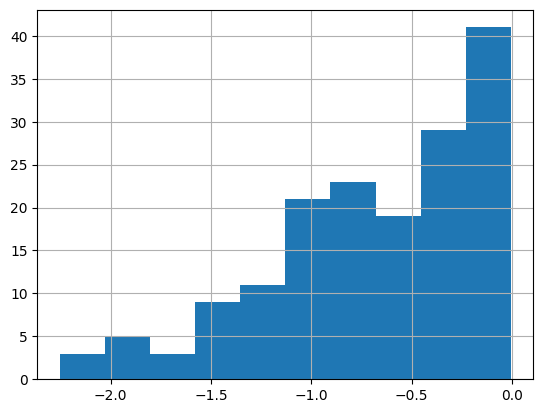

In [76]:
# difference in hours
purchse_to_carrier  = (orders["order_delivered_carrier_date"] - orders["order_purchase_timestamp"]).dt.total_seconds() / 3600

pur_to_car_neg = purchse_to_carrier[purchse_to_carrier < 0]
pur_to_car_neg_outliers = pur_to_car_neg[pur_to_car_neg < -100]

pur_to_car_neg[pur_to_car_neg > -100].hist();

 Also two of them have extremely large differences

In [82]:
pur_to_car_neg_outliers

25883   -4109.098056
83321    -101.461111
dtype: float64

For 23 observations order_delivered_carrier_date > order_delivered_customer_date, which is an anomaly.

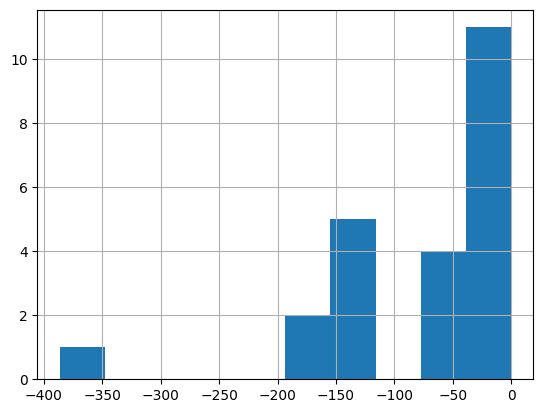

In [84]:
car_to_cust  = (orders["order_delivered_customer_date"] - orders["order_delivered_carrier_date"]).dt.total_seconds() / 3600
car_to_cust_neg = car_to_cust[car_to_cust < 0]
car_to_cust_neg.hist();

However purchase time percedes delivery to customer timestamp for every order.

In [85]:
pur_to_cust  = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.total_seconds() / 3600
pur_to_cust_neg = pur_to_cust[pur_to_cust < 0]
pur_to_cust_neg.shape

(0,)

### 3.2. order_delivered_customer_date <= review_creation_date <= review_answer_timestamp

review_creation_date show when the satisfaction survey was sent to a customer. The survey has been sent by 544 more times before customer recieved the order than after recieving it.

In [94]:
cust_to_rev  = (reviews["review_creation_date"] - orders["order_delivered_customer_date"]).dt.total_seconds() / 3600
cust_to_rev[cust_to_rev < 0].shape[0] - cust_to_rev[cust_to_rev > 0].shape[0]

544

Review answering was always after review creation.

In [88]:
rev_to_answ  = (reviews["review_answer_timestamp"] - reviews["review_creation_date"]).dt.total_seconds() / 3600
rev_to_answ_neg = rev_to_answ[rev_to_answ < 0]
rev_to_answ_neg.shape

(0,)

### 3.3. order_estimated_delivery_date vs order_delivered_carrier_date



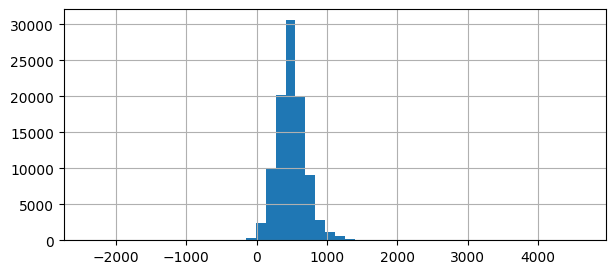

In [6]:
est_vs_real = (orders["order_estimated_delivery_date"] - orders["order_delivered_carrier_date"]).dt.total_seconds() / 3600
est_vs_real.hist(bins=50, figsize=(7, 3));

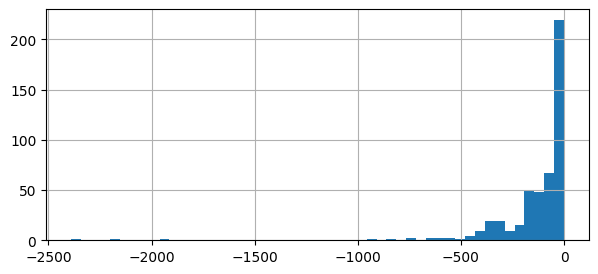

In [12]:
est_vs_real[est_vs_real < 0].hist(bins=50, figsize=(7, 3));

In [14]:
est_vs_real[est_vs_real > 0].shape[0] / est_vs_real.shape[0]

0.9773131806800012

In [19]:
est_vs_real_pos = est_vs_real[est_vs_real > 0]
est_vs_real_pos[int(est_vs_real_pos.sort_values().shape[0]*0.975)].mean()

202.11666666666667

Acctual delivery time is longer than esimated delivery time in 98% of cases. Excluding outliers this difference is 202 hours on average.

Series([], dtype: float64)

## 4. EDA

### 4.1 Univariate Analysis

In [ ]:
reviews.review_score.value_counts().plot.bar(x="review_score", rot=0)

From this plot we can say that review_scores will not be a valuable feature to identify potentialy popular products as the majority of ordrs are scored as 5.

In [ ]:
order_payments.payment_sequential.value_counts().plot.bar(x="index")

In [ ]:
order_payments.payment_installments.value_counts().plot.bar(x="index")

In [ ]:
order_payments.payment_type.value_counts()

In [ ]:
order_payments.payment_value.hist(bins=100)

In [ ]:
order_payments[order_payments.payment_value == 0]

In [ ]:
orders.order_status.value_counts()

In [ ]:
customers.customer_city.unique().shape

In [ ]:
customers.customer_zip_code_prefix.unique().shape

In [ ]:
customers.customer_state.value_counts().plot.bar(rot=0,  figsize=(10, 5))

In [ ]:
products.product_category_name.value_counts()

In [ ]:
products.head()

In [ ]:
mapping = {key: val for (key, val) in zip(product_category_name_translation.product_category_name,
                                product_category_name_translation.product_category_name_english)}
products["product_category_name_eng"] = products.product_category_name.map(mapping)

In [ ]:
products.product_category_name_eng.value_counts().sort_values().plot.barh(figsize=(7, 20), 
                                                                         ylabel="",
                                                                         grid=True);

In [ ]:
import matplotlib.pyplot as plt
num_cols = products.select_dtypes("float64").columns
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
k = 0  # index for num_cols
for i in range(3):
    for j in range(3):
        if k < len(num_cols):
            ax[i, j].hist(products[num_cols[k]], bins=20)
            ax[i, j].set_title(num_cols[k])
            k += 1
        else:
            ax[i, j].axis('off')

In [ ]:
#Number of orders by the number of items in the order
order_items.groupby("order_id").order_item_id.count().value_counts().plot.bar(rot=0);

In [ ]:
#sum to get the total freight value because each item in the order has its own freight value
bins = pd.cut(order_items.groupby("order_id").freight_value.sum(), bins=100).value_counts()
bins[bins > 0]

In [ ]:
sellers.seller_city.value_counts().head(10)

In [ ]:
# number of citeis by the number of selelrs in them
sellers.seller_city.value_counts().value_counts().sort_index(ascending=True).plot.bar(rot=0, figsize=(13, 5), xlabel="number of sellers in a city");

In [ ]:
sellers.seller_state.value_counts().plot.bar(rot=0, figsize=(10, 5));

### 4.2 Bivariate Analysis

In [ ]:
max_name = max(len(name) for name in datasets.keys())
max_feat = max(len(feat) for name, dset in datasets.items() for feat in dset.columns)
for dname, dset in datasets.items():
    features = [item.ljust(max_feat + 3) for item in dset.columns[dset.columns.str.find("id") < 0]]
    if len(features) > 4:
        print(dname.ljust(max_name), ":", "".join(features[:4]), "\n\n",
              " "*(max_name + 1), "".join(features[4:]), "\n\n")
    else:
        print(dname.ljust(max_name), ":", "".join(features), "\n\n")
        
  